## Cost prediction done by Prophet 
Prophet model
- GAM (Generative Additive Model)
-  g(t): Growth
- s(t): Seasonality
- h(t): holidays
- e(t): errors

  image.png

### Data set 
#### Inner data: Variable cost, fixed cost, material cost
#### External data: Exchange rate, Interest rate 
1. 2000-01-01~2011-12-01 (60% training dataset)
2. 2012-01-01~2020-12-1 (40% validation dataset1)
3. 2000-01-01!2020-12-01 (90% training dataset)
4. 2018-01-01~2020-12-1 (10% test dataset)
5. 2000-01-01~2020-12-1 (100% dataset)

In [2]:
!pip install pymysql

     |████████████████████████████████| 51kB 5.7MB/s 


### Data Extraction from database
- Data processing
- Seperate train vaildation data

In [3]:
#######################Prophet model
import pymysql
from datetime import datetime, timedelta
from fbprophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from math import sqrt
import numpy as np

#connect to database
dbCon = pymysql.connect(host='223.194.46.212', user='root', password='12345!', database='knowhow',
                       charset ='utf8', autocommit=True,
                       cursorclass=pymysql.cursors.DictCursor)

# Multivariate:Variable cost, fixed cost, material cost,exchange rate, interest rate  
#독립변수 5 항목: 고정비, 변동비, 재료비, 환률, 금리
y1='''SELECT cc_costbill.proamt_unit*cc_costbill.proq AS y, cc_costbill.periodym_cd*100 +1  AS ds
,cc_costbill.ic_dlvc+ cc_costbill.ic_ohdvc +cc_costbill.ic_idlc+cc_costbill.ic_idohc AS variablecost,
cc_costbill.ic_dlfc + cc_costbill.ic_ohdfe +cc_costbill.ic_ohdfd AS fixedcost,
cc_costbill.uc_srw AS materialcost,
cc_costbill.currency_usd as currency,
cc_costbill.interest_rate as interest
FROM cc_costbill;'''

curs = dbCon.cursor()
curs.execute(y1)
result =curs.fetchall()

#make DB table into pandas dataframe
df = pd.DataFrame(result)
#int -> datetime
df['ds'] = df['ds'].astype(str)
df['ds'] = pd.to_datetime(df['ds'])
df['currency']=df['currency'].astype(float)/3
df['interest']=df['interest'].astype(float)/3
df=df[['ds','y','variablecost','fixedcost', 'materialcost', 'currency','interest']]
df = df.groupby(['ds'], as_index=False)['y','variablecost','fixedcost', 'materialcost', 'currency','interest'].agg('sum')

#data set
x_train= df.loc[df['ds']<"2012-01-01"]#60%
x_test= df.loc[df['ds']>="2012-01-01"]#40%

x_train_1=df.loc[df['ds']<"2019-01-01"]#90%
x_test_1=df.loc[df['ds']>="2019-01-01"]#10%

print(df)

            ds          y  variablecost  ...  materialcost  currency  interest
0   2000-01-01  463224300      30552326  ...     324293351    1134.0      4.75
1   2000-02-01  465200989      30620382  ...     325347387    1121.0      5.00
2   2000-03-01  464540483      30601552  ...     325009160    1120.0      5.00
3   2000-04-01  465266511      30628607  ...     325330447    1110.0      5.00
4   2000-05-01  468261585      30743429  ...     327097996    1109.5      5.00
..         ...        ...           ...  ...           ...       ...       ...
247 2020-08-01  403275346      28545372  ...     301737785    1187.5      0.50
248 2020-09-01  402519866      28454414  ...     300837678    1186.9      0.50
249 2020-10-01  400176751      28383538  ...     300730547    1152.5      0.50
250 2020-11-01  398716028      28297018  ...     300267163    1117.0      0.50
251 2020-12-01  397247181      28270558  ...     299682076    1088.5      0.50

[252 rows x 7 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



## Created model using add_regression to predict Sales 
Train dataset
- 2000-01-01~2012-12-01 (60%)

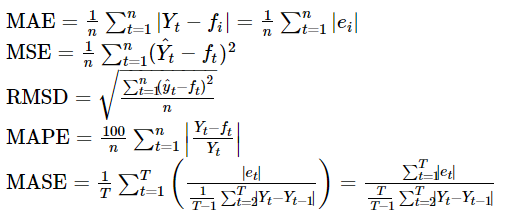

Train dataset
- 2000-01-01~2011-12-01 (60%) 
 Validation1 dataset
- 2012-01-01~2020-12-1 (40%)

MAE: 1363525.830
MSE: 2941706470760.944
RMSE: 1715140.365
RMSLE: 0.004
MAPE: 0.327 
SMAPE: 0.0008144284 


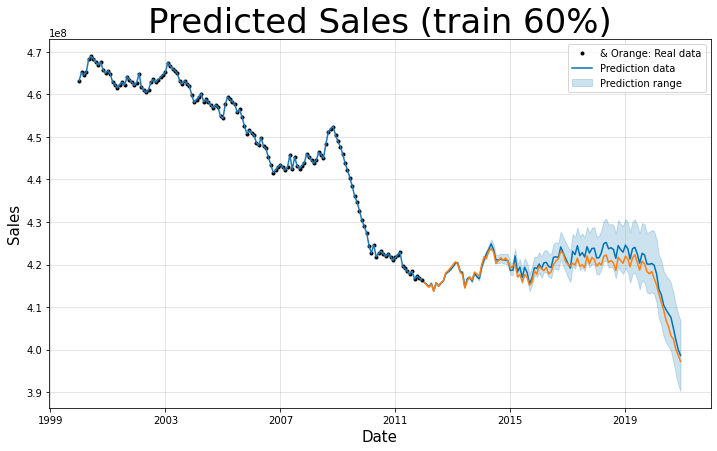

In [4]:
#Build model#################################
#covid19 trend (special events)
covid = pd.DataFrame({
'holiday': 'covid19',
'ds': pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01',
                     '2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
                     '2020-09-01','2020-10-01','2020-11-01','2020-12-01',]),
'lower_window': -1,
'upper_window': 0,
})
#inflation
inflation = pd.DataFrame({
'holiday': 'inflation',
'ds': pd.to_datetime(['2009-01-01', '2009-02-01','2009-03-01',
                     '2009-04-01','2009-05-01','2009-06-01','2009-07-01','2009-08-01',
                     '2009-09-01','2009-10-01','2009-11-01','2009-12-01',]),
'lower_window': -1,
'upper_window': 0,
})

holidays = pd. concat((covid, inflation))
model_60= Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
# Uncertainty Intervals: 20%
    interval_width = 0.2,
    holidays=holidays
)
#Add monthly pattern because data is month based data / 월주기 패턴 추가 /
model_60.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
#add regressor
model_60.add_regressor('variablecost',prior_scale=0.5, mode='multiplicative')#변동비
model_60.add_regressor('fixedcost',prior_scale=0.5, mode='multiplicative')#고정비
model_60.add_regressor('materialcost', prior_scale=0.5, mode='multiplicative')#재료비
model_60.add_regressor('currency', prior_scale=0.5, mode='multiplicative')#환률
model_60.add_regressor('interest', prior_scale=0.5, mode='multiplicative')#금리

#train model 90%
model_60.fit(x_train)

#Data validation 10% 데이터 확인 10%
forecast_60=model_60.predict(x_test)
fig = model_60.plot(forecast_60, uncertainty=True, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Predicted Sales (train 60%)", size=34)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Sales", size=15)
ax.tick_params(axis="x",)
ax.tick_params(axis="y",)
plt.legend(['& Orange: Real data','Prediction data','Prediction range'])
plt.plot(x_train['ds'], x_train['y'])
plt.plot(x_test['ds'], x_test['y'])

plt.show

#Validation
mae = mean_absolute_error(x_test['y'], forecast_60['yhat'])
MSE = mean_squared_error(x_test['y'], forecast_60['yhat'])
RMSE = np.sqrt(MSE)
RMSLE = np.sqrt(mean_squared_log_error(x_test['y'], forecast_60['yhat']))
r2 = r2_score(x_test['y'], forecast_60['yhat'])
print('MAE: %.3f' % mae)
print('MSE: %.3f' % MSE)
print('RMSE: %.3f' % RMSE)
print('RMSLE: %.3f' % RMSLE)

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def smape(y, y_hat):
    y, y_hat = np.array(y), np.array(y_hat)
    return np.nanmean(np.abs(y-y_hat)/ ((y+y_hat)*2))

print('MAPE:% .3f ' %mean_absolute_percentage_error(y_true=x_test['y'],
                   y_pred=forecast_60['yhat']))
print('SMAPE:% .10f ' %smape(x_test['y'],forecast_60['yhat']))

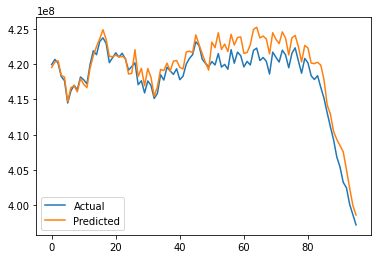

In [5]:
#60% train set validation check
y_true = df['y'][-96:].values

y_predict=forecast_60['yhat'][-96:].values
plt.plot(y_true, label='Actual')
plt.plot(y_predict, label='Predicted')

plt.legend()
plt.show()

 Validation dataset
- 2018-01-01~2020-12-1 (10%)

MAE: 450783.678
MSE: 477625368666.379
RMSE: 691104.456
RMSLE: 0.002
MAPE: 0.111 
SMAPE: 0.0002760712 


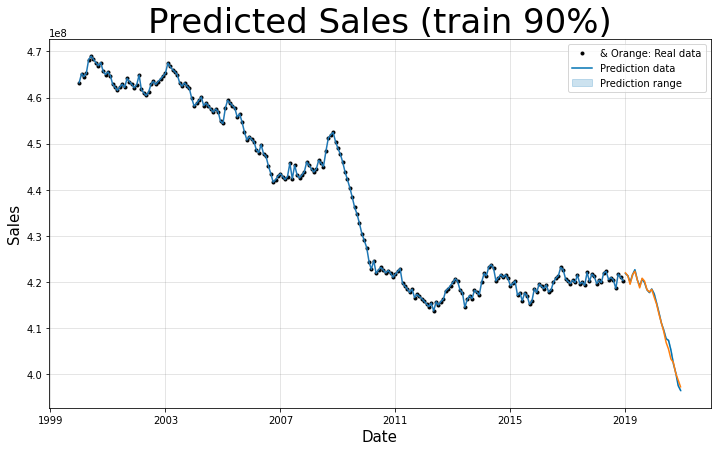

In [6]:
#train 90%
#Build model#################################
#covid19 trend (special events)
covid = pd.DataFrame({
'holiday': 'covid19',
'ds': pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01',
                     '2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
                     '2020-09-01','2020-10-01','2020-11-01','2020-12-01',]),
'lower_window': -1,
'upper_window': 0,
})
#inflation
inflation = pd.DataFrame({
'holiday': 'inflation',
'ds': pd.to_datetime(['2009-01-01', '2009-02-01','2009-03-01',
                     '2009-04-01','2009-05-01','2009-06-01','2009-07-01','2009-08-01',
                     '2009-09-01','2009-10-01','2009-11-01','2009-12-01',]),
'lower_window': -1,
'upper_window': 0,
})

holidays = pd. concat((covid, inflation))
model_90= Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
# Uncertainty Intervals: 20%
    interval_width = 0.2,
    holidays=holidays
)
#Add monthly pattern because data is month based data / 월주기 패턴 추가 /
model_90.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
#add regressor
model_90.add_regressor('variablecost',prior_scale=0.5, mode='multiplicative')#변동비
model_90.add_regressor('fixedcost',prior_scale=0.5, mode='multiplicative')#고정비
model_90.add_regressor('materialcost', prior_scale=0.5, mode='multiplicative')#재료비
model_90.add_regressor('currency', prior_scale=0.5, mode='multiplicative')#환률
model_90.add_regressor('interest', prior_scale=0.5, mode='multiplicative')#금리

#train model 90%
model_90.fit(x_train_1)

#Data validation 10% 데이터 확인 10%
forecast_1=model_90.predict(x_test_1)
fig = model_90.plot(forecast_1, uncertainty=True, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Predicted Sales (train 90%)", size=34)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Sales", size=15)
ax.tick_params(axis="x",)
ax.tick_params(axis="y",)
plt.legend(['& Orange: Real data','Prediction data','Prediction range'])
plt.plot(x_train_1['ds'], x_train_1['y'])
plt.plot(x_test_1['ds'], x_test_1['y'])

plt.show

#Validation
mae = mean_absolute_error(x_test_1['y'], forecast_1['yhat'])
MSE = mean_squared_error(x_test_1['y'], forecast_1['yhat'])
RMSE = np.sqrt(MSE)
RMSLE = np.sqrt(mean_squared_log_error(x_test_1['y'], forecast_1['yhat']))
r2 = r2_score(x_test_1['y'], forecast_1['yhat'])
print('MAE: %.3f' % mae)
print('MSE: %.3f' % MSE)
print('RMSE: %.3f' % RMSE)
print('RMSLE: %.3f' % RMSLE)

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def smape(y, y_hat):
    y, y_hat = np.array(y), np.array(y_hat)
    return np.nanmean(np.abs(y-y_hat)/ ((y+y_hat)*2))

print('MAPE:% .3f ' %mean_absolute_percentage_error(y_true=x_test_1['y'],
                   y_pred=forecast_1['yhat']))
print('SMAPE:% .10f ' %smape(x_test_1['y'],forecast_1['yhat']))

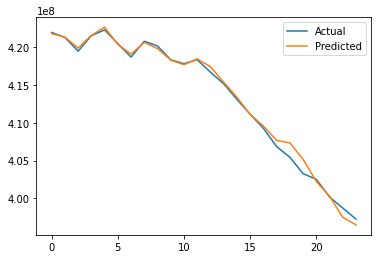

In [7]:
#90% train set validation check
y_true = df['y'][-24:].values

y_predict=forecast_1['yhat'][-24:].values
plt.plot(y_true, label='Actual')
plt.plot(y_predict, label='Predicted')

plt.legend()
plt.show()

# Train 2000-01-01~2020-12-01 model
- Predict 3 months

## When predicting Multivariate prophet model you need future data of outer data
- This process is to predict variable cost, fixed cost, material cost, currency, interest rate's 12 months prediction to predict sales.

#### Build Model
- Add holidays (inflation, COVID19)
- Add regression

#### Multivariate values
- Variable cost, fixed cost, material cost,exchange rate, interest rate

            ds         y
0   2000-01-01  30552326
1   2000-02-01  30620382
2   2000-03-01  30601552
3   2000-04-01  30628607
4   2000-05-01  30743429
..         ...       ...
247 2020-08-01  28545372
248 2020-09-01  28454414
249 2020-10-01  28383538
250 2020-11-01  28297018
251 2020-12-01  28270558

[252 rows x 2 columns]


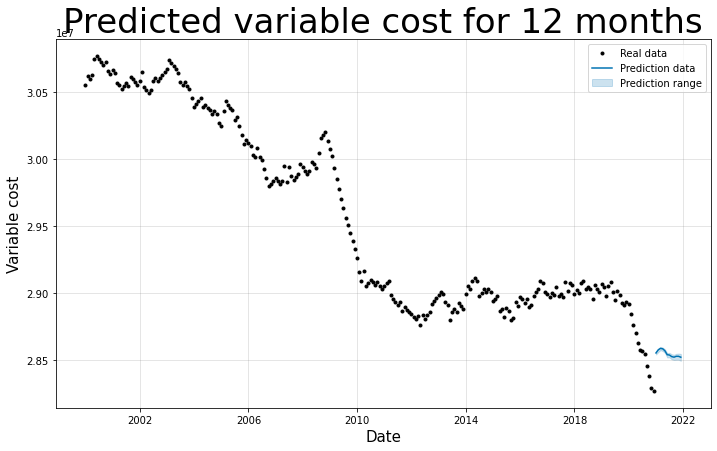

In [33]:
#Build model variable cost/ 모델 만들기#################################
covid = pd.DataFrame({
'holiday': 'covid19',
'ds': pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01',
                     '2020-04-01','2020-05-01','2020-06-01','2020-07-01','2020-08-01',
                     '2020-09-01','2020-10-01','2020-11-01','2020-12-01',]),
'lower_window': -1,
'upper_window': 0,
})
#inflation
inflation = pd.DataFrame({
'holiday': 'inflation',
'ds': pd.to_datetime(['2009-01-01', '2009-02-01','2009-03-01',
                     '2009-04-01','2009-05-01','2009-06-01','2009-07-01','2009-08-01',
                     '2009-09-01','2009-10-01','2009-11-01','2009-12-01',]),
'lower_window': -1,
'upper_window': 0,
})

holidays = pd. concat((covid, inflation))
#변동비 모델
model_variable= Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
# Uncertainty Intervals: 95%
    interval_width = 0.20,
    holidays=holidays
)
#Add monthly pattern because data is month based data / 월주기 패턴 추가 /
model_variable.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)


#predict outer variables
#data processing before predict future
future = list()
for i in range(1, 13):
	date = '2021-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

future_outerdata = df[:].values
future_outerdata=pd.DataFrame(future_outerdata)
future_outerdata.columns=['ds','y','variablecost', 'fixedcost','materialcost','currency','interest']


#변동비 예측
future_variable=future_outerdata[['ds','variablecost']]
future_variable.columns=['ds','y']
model_variable.fit(future_variable)
print(future_variable)
future_variable=model_variable.predict(future)

# summarize the forecast
# print(future_variable[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
fig = model_variable.plot(future_variable, uncertainty=True, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Predicted variable cost for 12 months", size=34)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Variable cost", size=15)
ax.tick_params(axis="x",)
ax.tick_params(axis="y",)
plt.legend(['Real data','Prediction data','Prediction range'])
plt.show()

            ds         y
0   2000-01-01  51188011
1   2000-02-01  51284534
2   2000-03-01  51264268
3   2000-04-01  51288208
4   2000-05-01  51399963
..         ...       ...
247 2020-08-01  48114607
248 2020-09-01  47953815
249 2020-10-01  47823008
250 2020-11-01  47670791
251 2020-12-01  47588345

[252 rows x 2 columns]


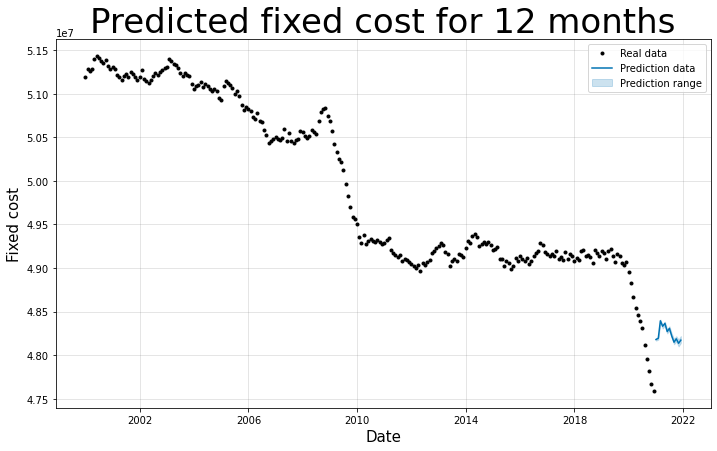

In [32]:
#Fixed cost model / 고정비 모델
model_fixed= Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
# Uncertainty Intervals: 95%
    interval_width = 0.20,
    holidays=holidays
)
#Add monthly pattern because data is month based data / 월주기 패턴 추가 /
model_fixed.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

# 고정비 예측
future_fixed=future_outerdata[['ds','fixedcost']]
future_fixed.columns=['ds','y']
model_fixed.fit(future_fixed)
print(future_fixed)
future_fixed=model_fixed.predict(future)

fig = model_fixed.plot(future_fixed, uncertainty=True, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Predicted fixed cost for 12 months", size=34)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Fixed cost", size=15)
ax.tick_params(axis="x",)
ax.tick_params(axis="y",)
plt.legend(['Real data','Prediction data','Prediction range'])
plt.show()

            ds          y
0   2000-01-01  324293351
1   2000-02-01  325347387
2   2000-03-01  325009160
3   2000-04-01  325330447
4   2000-05-01  327097996
..         ...        ...
247 2020-08-01  301737785
248 2020-09-01  300837678
249 2020-10-01  300730547
250 2020-11-01  300267163
251 2020-12-01  299682076

[252 rows x 2 columns]


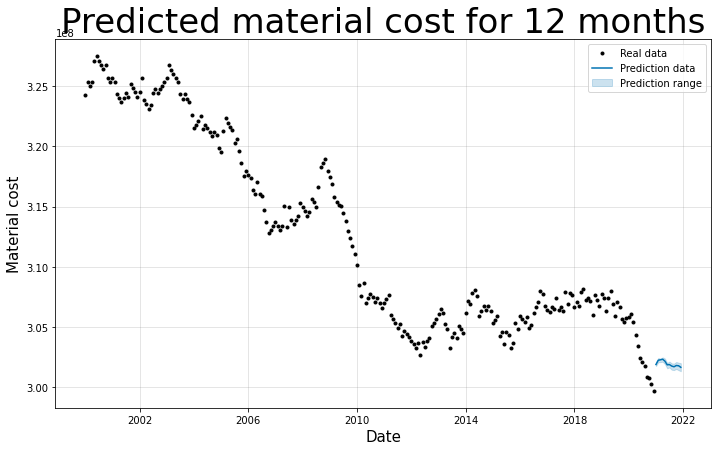

In [30]:
#Material cost model / 재료비 모델
model_material= Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
# Uncertainty Intervals: 95%
    interval_width = 0.20,
    holidays=holidays
)
#Add monthly pattern because data is month based data / 월주기 패턴 추가 /
model_material.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

# 재료비 예측
future_material=future_outerdata[['ds','materialcost']]
future_material.columns=['ds','y']
model_material.fit(future_material)
print(future_material)
future_material=model_material.predict(future)

fig = model_material.plot(future_material, uncertainty=True, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Predicted material cost for 12 months", size=34)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Material cost", size=15)
ax.tick_params(axis="x",)
ax.tick_params(axis="y",)
plt.legend(['Real data','Prediction data','Prediction range'])
plt.show()


            ds       y
0   2000-01-01    1134
1   2000-02-01    1121
2   2000-03-01    1120
3   2000-04-01    1110
4   2000-05-01  1109.5
..         ...     ...
247 2020-08-01  1187.5
248 2020-09-01  1186.9
249 2020-10-01  1152.5
250 2020-11-01    1117
251 2020-12-01  1088.5

[252 rows x 2 columns]


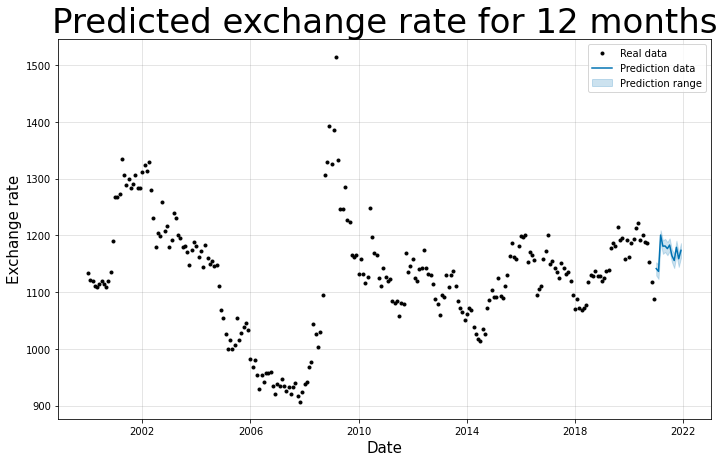

In [29]:
#Exchange raet model / 환률 모델
model_currency= Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
# Uncertainty Intervals: 95%
    interval_width = 0.20,
    holidays=holidays
)
#Add monthly pattern because data is month based data / 월주기 패턴 추가 /
model_currency.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

# 환률 예측
future_currency=future_outerdata[['ds','currency']]
future_currency.columns=['ds','y']
model_currency.fit(future_currency)
print(future_currency)
future_currency=model_currency.predict(future)

fig = model_currency.plot(future_currency, uncertainty=True, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Predicted exchange rate for 12 months", size=34)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Exchange rate", size=15)
ax.tick_params(axis="x",)
ax.tick_params(axis="y",)
plt.legend(['Real data','Prediction data','Prediction range'])
plt.show()

            ds     y
0   2000-01-01  4.75
1   2000-02-01     5
2   2000-03-01     5
3   2000-04-01     5
4   2000-05-01     5
..         ...   ...
247 2020-08-01   0.5
248 2020-09-01   0.5
249 2020-10-01   0.5
250 2020-11-01   0.5
251 2020-12-01   0.5

[252 rows x 2 columns]


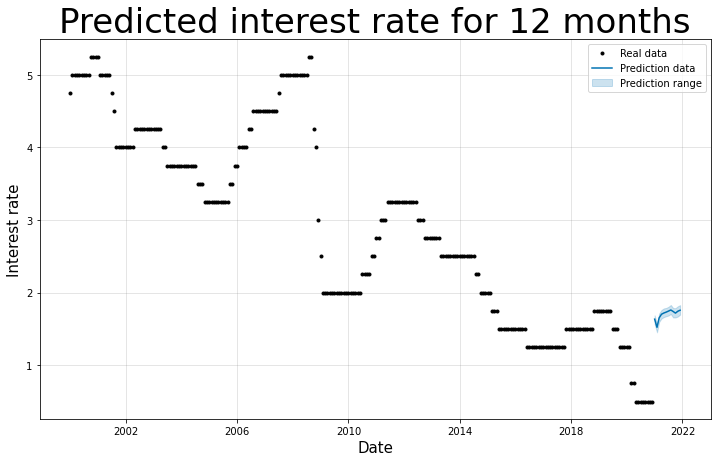

In [28]:
#interest raet model / 금리 모델
model_interest= Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
# Uncertainty Intervals: 95%
    interval_width = 0.20,
    holidays=holidays
)
#Add monthly pattern because data is month based data / 월주기 패턴 추가 /
model_interest.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

# 환률 예측
future_interest=future_outerdata[['ds','interest']]
future_interest.columns=['ds','y']
model_interest.fit(future_interest)
print(future_interest)
future_interest=model_interest.predict(future)

fig = model_interest.plot(future_interest, uncertainty=True, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Predicted interest rate for 12 months", size=34)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Interest rate", size=15)
ax.tick_params(axis="x",)
ax.tick_params(axis="y",)
plt.legend(['Real data','Prediction data','Prediction range'])
plt.show()

            ds          y  variablecost  ...  materialcost  currency  interest
0   2000-01-01  463224300      30552326  ...     324293351    1134.0      4.75
1   2000-02-01  465200989      30620382  ...     325347387    1121.0      5.00
2   2000-03-01  464540483      30601552  ...     325009160    1120.0      5.00
3   2000-04-01  465266511      30628607  ...     325330447    1110.0      5.00
4   2000-05-01  468261585      30743429  ...     327097996    1109.5      5.00
..         ...        ...           ...  ...           ...       ...       ...
247 2020-08-01  403275346      28545372  ...     301737785    1187.5      0.50
248 2020-09-01  402519866      28454414  ...     300837678    1186.9      0.50
249 2020-10-01  400176751      28383538  ...     300730547    1152.5      0.50
250 2020-11-01  398716028      28297018  ...     300267163    1117.0      0.50
251 2020-12-01  397247181      28270558  ...     299682076    1088.5      0.50

[252 rows x 7 columns]


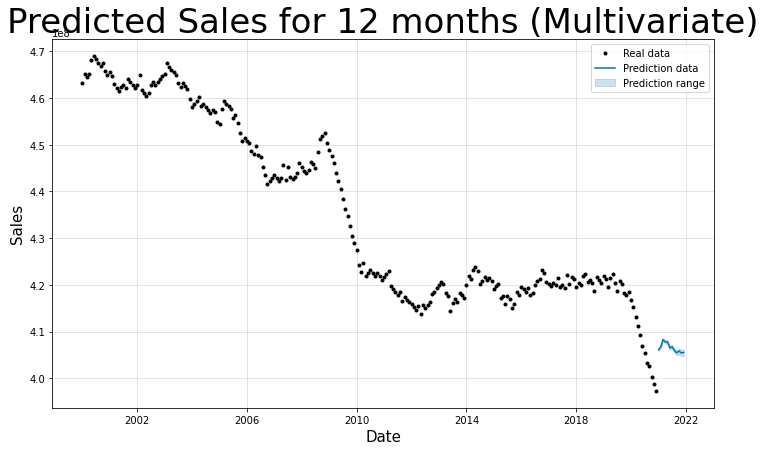

In [39]:
#add_regression model
model= Prophet(
    # trend
    changepoint_prior_scale=0.3,
    # seasonality
    weekly_seasonality=False,
    yearly_seasonality=20,
    daily_seasonality=False,
# Uncertainty Intervals: 95%
    interval_width = 0.95,
    holidays=holidays
)
#Add monthly pattern because data is month based data / 월주기 패턴 추가 /
model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

future.isna().sum()
#add regressor
model.add_regressor('variablecost',prior_scale=0.5, mode='multiplicative')#변동비
model.add_regressor('fixedcost',prior_scale=0.5, mode='multiplicative')#고정비
model.add_regressor('materialcost', prior_scale=0.5, mode='multiplicative')#재료비
model.add_regressor('currency', prior_scale=0.3, mode='multiplicative')#환률
model.add_regressor('interest', prior_scale=0.3, mode='multiplicative')#금리

forecast=df[['ds','y','variablecost','fixedcost','materialcost','currency', 'interest']]
print(forecast)
#df의 3요소만
model.fit(forecast)

result3 = pd.concat([future_variable['ds'],future_variable['yhat'], future_fixed['yhat'], future_material['yhat'], future_currency['yhat'], future_interest['yhat']],axis=1)
result3.columns=['ds','variablecost','fixedcost', 'materialcost', 'currency', 'interest']
# print(result3)
future=model.predict(result3)

fig = model.plot(future, uncertainty=True, xlabel='Date', ylabel='Value')
ax = fig.gca()
ax.set_title("Predicted Sales for 12 months (Multivariate)", size=34)
ax.set_xlabel("Date", size=15)
ax.set_ylabel("Sales", size=15)
ax.tick_params(axis="x",)
ax.tick_params(axis="y",)
plt.legend(['Real data','Prediction data','Prediction range'])
# plt.plot(df['ds'], df['y'] )
plt.show()


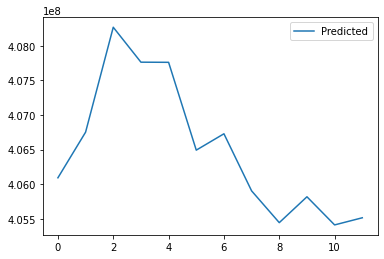

In [35]:
y_predict=future['yhat'][-12:].values
plt.plot(y_predict, label='Predicted')

plt.legend()
plt.show()

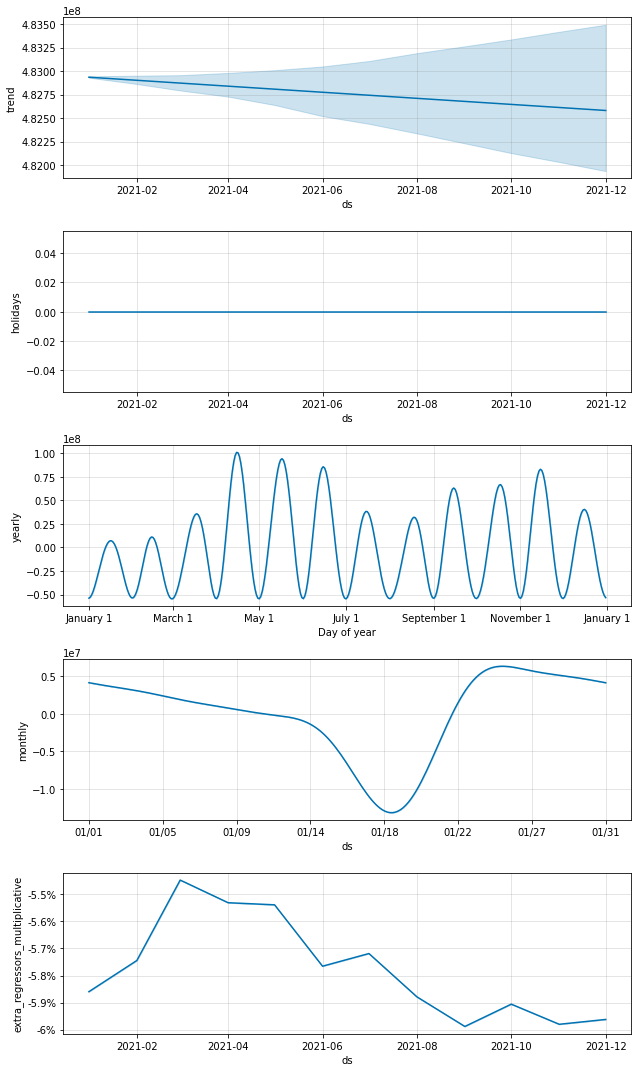

In [36]:
fig1 = model.plot_components(future)